In [2]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler
import cProfile

In [174]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

In [8]:
bk.load.current_session_linux()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


True

In [132]:
def states_fr(local_path = 'Rat08/Rat08-20130713',arg = None):
    if arg == None : pass
    
    bk.load.current_session_linux(local_path = local_path)
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()
    
    del states['drowsy']
    
    fr_states = pd.DataFrame()
    for s,intervals in states.items():
        fr = []
        for n in neurons:
            fr.append(len(n.restrict(intervals))/intervals.tot_length(time_units = 's'))
        fr_states[s] = fr
    
    tot_spikes = [len(n) for n in neurons]
    
    fr_states['tot_spikes'] = tot_spikes
    metadata['SessID'] = metadata.index
    
    return pd.concat((metadata,fr_states),axis=1)

In [160]:
def merge_state_fr(batch,discard,remove):
    all_fr = pd.DataFrame()
    for session,fr in batch.items():
        if session in discard: continue
        all_fr = pd.concat((all_fr,fr))
    all_fr.index = np.arange(0,len(all_fr),1)
    
    if remove: all_fr = all_fr.drop(index=all_fr[all_fr['Rem']==0].index)
    return all_fr

In [162]:
# batch = bk.load.batch(states_fr,arg = None,linux=True)
discard = ['Rat08-20130718','Rat09-20140408','Rat09-20140409','Rat10-20140619','Rat10-20140620','Rat10-20140622','Rat11-20150316']
all_fr = merge_state_fr(batch,discard,True)

In [686]:
def plot_all_fr(all_fr,stru):
    '''
    Plot 
     - Violin 
     - CumFreq
     - Dot Plot REM/Wake - NREM/Wake - REM/NREM
    '''
    states = ['Rem','sws','wake']

    
    all_fr_stru = all_fr[(all_fr.Region == stru)]
    
    
    df = pd.melt(all_fr_stru,value_vars=['Rem','sws','wake'],id_vars = 'Type')
    df['value'] = np.log10(df['value'])

    fig,ax = plt.subplot_mosaic('''AAAAAA
                                   BBBCCC
                                   DDEEFF''',figsize= (12,8),dpi = 200)
    
    plt.suptitle('Firing Rates of neurons in the BLA')
    
    
    ### Violin plots
    plt.sca(ax['A'])
    ax['A'].set_title('Violin Plots')
    
    sns.violinplot(x = 'variable',y = 'value',hue = 'Type',split = True,scale = 'count',data = df,palette='mako',gridsize=1000)
    ax['A'].set_xlabel('States')
    ax['A'].set_ylabel('FiringRates')
    y_ticks = np.arange(-3,4)
    plt.yticks(y_ticks,pow(10.0,y_ticks))
    
    ### Cumsum Pyr
    plt.sca(ax['B'])
    for s in states:
        fr = np.log10(all_fr_stru[s][all_fr_stru.Type == 'Pyr'])
        c = cum_sum_pyr = scipy.stats.cumfreq(fr,100)
        x = c.lowerlimit + np.linspace(0, c.binsize*c.cumcount.size,c.cumcount.size)
        ax['B'].plot(x,c[0])
    x_ticks = np.arange(-3,3)
    plt.xticks(x_ticks,pow(10.0,x_ticks))
    plt.yticks(np.arange(0,2001,500))
    
    plt.title('Pyr CumSum')
    plt.legend(states)
    
    ### Cumsum Int
    
    plt.sca(ax['C'])
    for s in states:
        fr = np.log10(all_fr_stru[s][all_fr_stru.Type == 'Int'])
        c = cum_sum_pyr = scipy.stats.cumfreq(fr,100)
        x = c.lowerlimit + np.linspace(0, c.binsize*c.cumcount.size,c.cumcount.size)
        ax['C'].plot(x,c[0])
    x_ticks = np.arange(-3,3)
    plt.xticks(x_ticks,pow(10.0,x_ticks))
    plt.yticks(np.arange(0,301,50))
    
    plt.title('Int CumSum')
    
    '''
    Dot plot Starts Here :
    '''
    
    axes = ['D','E','F']
    states = [['Rem','wake'],['sws','wake'],['Rem','sws']]
    
    for a,s in zip(axes,states):
        fr_pyr_0 = all_fr_stru[s[0]][all_fr_stru.Type == 'Pyr']
        fr_pyr_1 = all_fr_stru[s[1]][all_fr_stru.Type == 'Pyr']
        
        fr_int_0 = all_fr_stru[s[0]][all_fr_stru.Type == 'Int']
        fr_int_1 = all_fr_stru[s[1]][all_fr_stru.Type == 'Int']
        
        ###LinReg
        linreg = scipy.stats.linregress(fr_pyr_0,fr_pyr_1)
        linreg = scipy.stats.linregress(np.log10(fr_pyr_0),np.log10(fr_pyr_1))

        m = linreg.slope
        b = linreg.intercept
#         x = np.linspace(0,1000,1000)
#         y = (x*linreg.slope) + linreg.intercept
        x = np.linspace(-3, 3,500000)
        y = (m*x + b) 
        
        x = 10**x
        y = 10**y
        
#         ax[a].loglog(10**x,10**y,'r')
        ax[a].scatter(fr_pyr_0,fr_pyr_1,color = '#495084ff',s = 1)
        ax[a].scatter(fr_int_0,fr_int_1,color = '#479c9eff', s = 1)
        ax[a].loglog(x, y, c='orange', label="fit")

        
        
        ax[a].set_xlim([0.001,1000])
        ax[a].set_ylim([0.001,1000])
        
        ax[a].set_xlabel(s[0])
        ax[a].set_ylabel(s[1])
        ax[a].set_title('DotPlots')
    
    
    plt.tight_layout()
    
    plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/states_fr.svg')

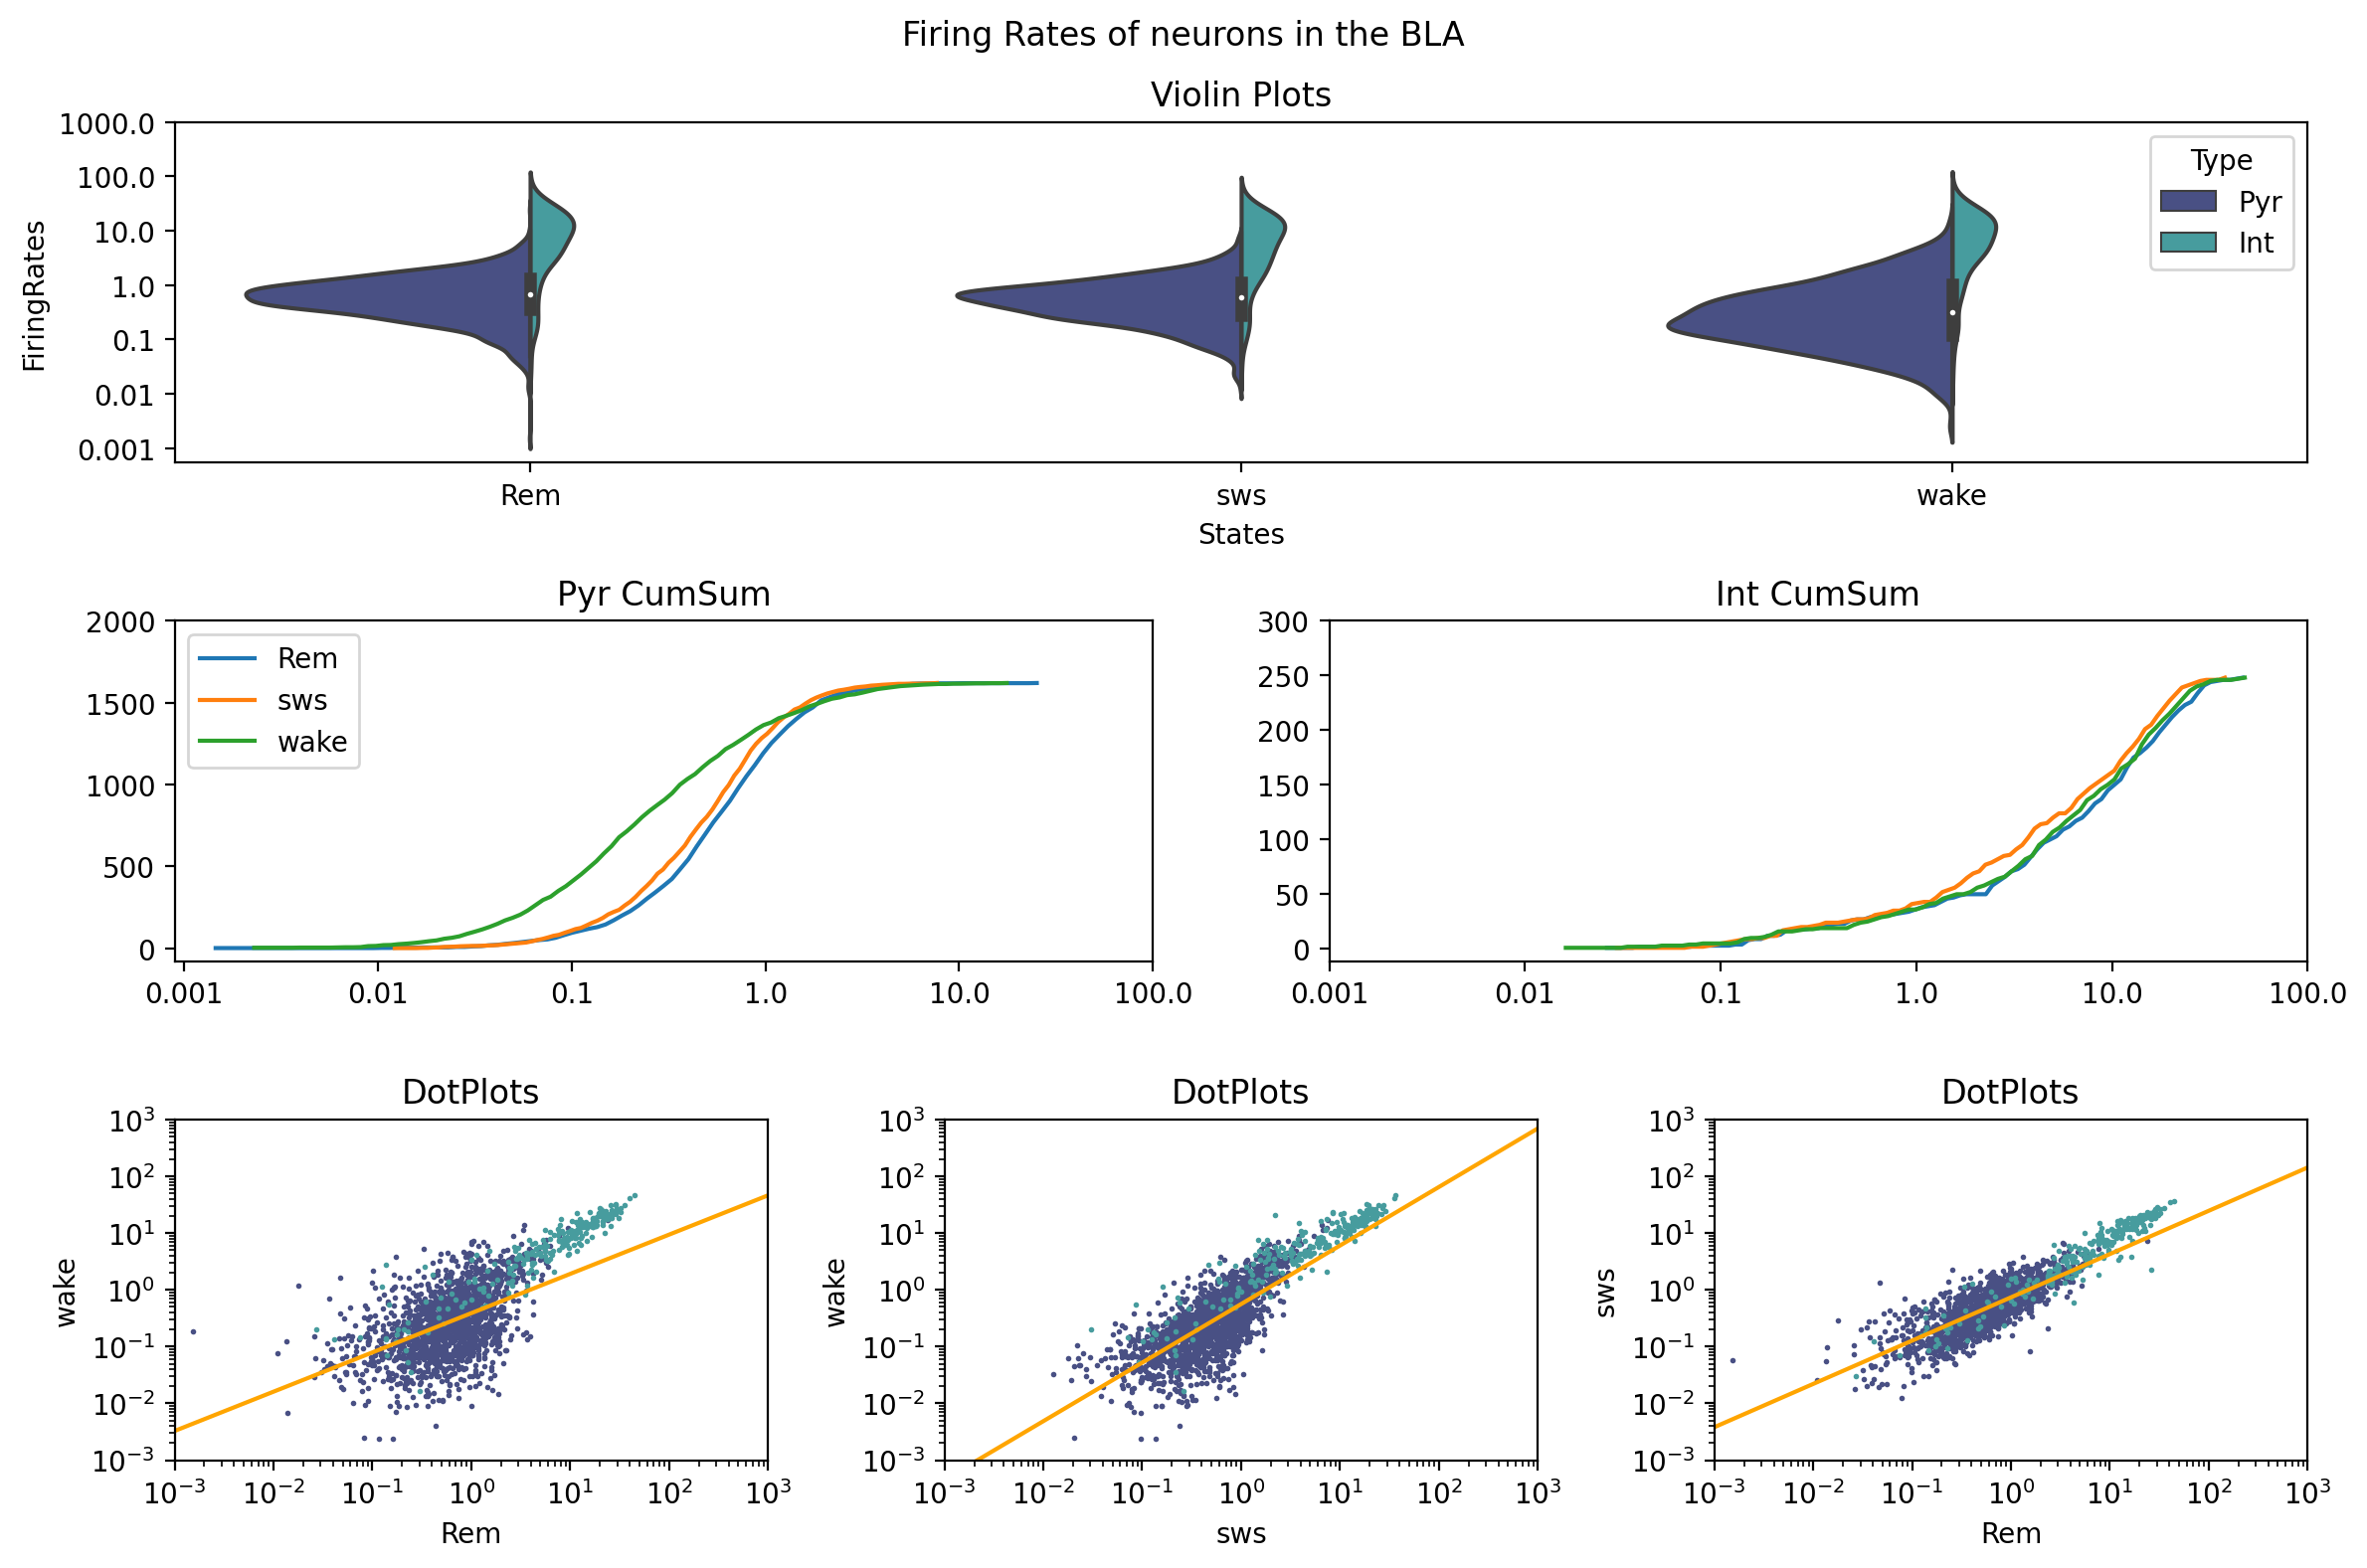

In [687]:
plot_all_fr(all_fr,'BLA')

/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  after removing the cwd from sys.path.
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


(3.419067303840693, 1000)

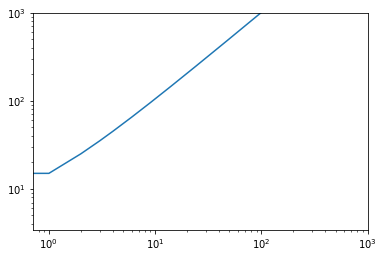

In [626]:
x = np.linspace(0,1000,1000)
y = x*10 +5
plt.loglog(x,y)
plt.xlim([0,1000])
plt.ylim([0,1000])